<b>Variational Autoencoder</b>

In [ ]:
import numpy as np
import torch

seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
# Dataset

from torchvision import datasets, transforms
import torch.utils as utils

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1))])

dataset_train = datasets.MNIST(
    '~/mnist', 
    train=True, 
    download=True, 
    transform=transform)
dataset_test  = datasets.MNIST(
    '~/mnist', 
    train=False, 
    download=True, 
    transform=transform)

batch_size = 1000

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)
dataloader_test  = utils.data.DataLoader(dataset_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

Extracting /root/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/mnist/MNIST/raw


Extracting /root/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/mnist/MNIST/raw


Extracting /root/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/mnist/MNIST/raw


Extracting /root/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Network

import torch.nn as nn

class VAE(nn.Module):
  def __init__(self, z_dim):
    super(VAE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 300),
        nn.ReLU(),
        nn.Linear(300, 200),
        nn.ReLU(),
    )
    self.encmean = nn.Sequential(
        nn.Linear(200, z_dim),
    )
    self.encvar = nn.Sequential(
        nn.Linear(200, z_dim),
        nn.Softplus()
    )
    self.decoder = nn.Sequential(
        nn.Linear(z_dim, 200),
        nn.ReLU(),
        nn.Linear(200, 300),
        nn.ReLU(),
        nn.Linear(300, 28*28),
        nn.Sigmoid(),
    )

  def sample_z(self, mean, var):
    epsilon = torch.randn(mean.shape).to(device)
    return mean + torch.sqrt(var) * epsilon

  def forward(self, x1):
    x2 = self.encoder(x1)
    mean = self.encmean(x2)
    var = self.encvar(x2)
    z = self.sample_z(mean, var)
    y = self.decoder(z)
    return y, z

  def loss(self, x1):
    x2 = self.encoder(x1)
    mean = self.encmean(x2)
    var = self.encvar(x2)
    KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var))
    z = self.sample_z(mean, var)
    y = self.decoder(z)
    reconstruction = torch.mean(torch.sum(x1 * torch.log(y) + (1 - x1) * torch.log(1 - y)))
    lower_bound = [-KL, reconstruction]                                      
    return -sum(lower_bound)

In [ ]:
# Training

from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for i in range(20):
  print(f"EPOCH: {i+1}")

  ### Train ###
  model.train()
  for x, _ in dataloader_train:
    x = x.to(device)
    model.zero_grad()
    y, _ = model(x)
    loss = model.loss(x)/batch_size
    loss.backward()
    optimizer.step()

  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for x, _ in dataloader_train:
    x = x.to(device)
    y, _ = model(x)
    loss = model.loss(x)/batch_size
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  train loss: {sum_loss/sum_iter}")

  ### Test ###
  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for x, _ in dataloader_test:
    x = x.to(device)
    y, _ = model(x)
    loss = model.loss(x)/batch_size
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  test  loss: {sum_loss/sum_iter}")


EPOCH: 1
  train loss: 202.90272954305013
  test  loss: 202.62072143554687
EPOCH: 2
  train loss: 188.52353006998698
  test  loss: 187.77914581298828
EPOCH: 3
  train loss: 168.9038874308268
  test  loss: 168.1025863647461
EPOCH: 4
  train loss: 157.45878982543945
  test  loss: 156.69292755126952
EPOCH: 5
  train loss: 143.894908396403
  test  loss: 142.93766021728516
EPOCH: 6
  train loss: 136.43392639160157
  test  loss: 135.46041717529297
EPOCH: 7
  train loss: 132.6405471801758
  test  loss: 131.803955078125
EPOCH: 8
  train loss: 130.2843095143636
  test  loss: 129.40542449951172
EPOCH: 9
  train loss: 128.09082196553547
  test  loss: 127.25931243896484
EPOCH: 10
  train loss: 126.05737075805663
  test  loss: 125.21846313476563
EPOCH: 11
  train loss: 124.70150006612143
  test  loss: 123.79019241333008
EPOCH: 12
  train loss: 122.97598025004069
  test  loss: 122.1410400390625
EPOCH: 13
  train loss: 121.69260203043619
  test  loss: 120.81389923095703
EPOCH: 14
  train loss: 120.68

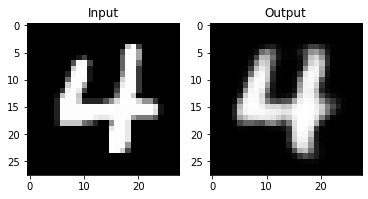

In [ ]:
# Visualization

import matplotlib.pyplot as plt
%matplotlib inline

x, t = iter(dataloader_test).next()
x = x.to(device)
y, _ = model(x)
x = np.reshape(x[0].cpu().detach().numpy(), [28, 28])
y = np.reshape(y[0].cpu().detach().numpy(), [28, 28])

plt.gray()
plt.subplot(121)
plt.imshow(x)
plt.title("Input")
plt.subplot(122)
plt.imshow(y)
plt.title("Output")
plt.show()

参考<br>
https://www.sambaiz.net/article/212/<br>
https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24<br>